# Multi-output Gaussian Processes in PyMC [GSoC Week 07-09]

> A personal note on the progress of incoporating Multi-output Gaussian Processes (MOGPs) into PyMC. Week 07-09 focuses on implementing ICM and LCM using Hadamard (element-wise) product.
- toc: true 
- badges: true
- comments: true
- categories: [GP, Gaussian Process, Hadamard Product]

**This work is supported by GSoC, NumFOCUS, and PyMC team**

Given input data $x$ and different outputs $o$, the ICM kernel $K$ is calculated by Hadamard or element-wise product:
$$
K = K_1(x, x') * K_2(o, o') 
$$

Where $K_2(o, o')$ is broadcast into the shape of input data $K_2(x, x')$ using Coregion kernel.

NOTE: This Hadamard product can work with same input data or different input data.

In [1]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
# set the seed
np.random.seed(1)
from multi_ouputs import build_XY, ICM, LCM, MultiMarginal
from mo import MultiOutputMarginal

In [2]:
import math
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

### Set up training data

In [3]:
N = 50
train_x = np.linspace(0, 1, N)

train_y = np.stack([
    np.sin(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (1 * math.pi)) + np.random.randn(len(train_x)) * 0.1,
], -1)

In [4]:
train_x.shape, train_y.shape

((50,), (50, 3))

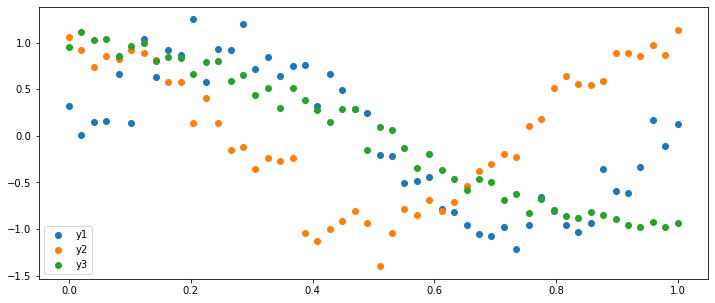

In [5]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.scatter(train_x, train_y[:,0])
ax.scatter(train_x, train_y[:,1])
ax.scatter(train_x, train_y[:,2])
plt.legend(["y1", "y2", "y3"])

In [6]:
train_x.shape, train_y.shape

((50,), (50, 3))

In [7]:
np.vstack([train_y[:,0], train_y[:,1], train_y[:,2]]).shape

(3, 50)

In [8]:
x = train_x.reshape(-1,1)
X, Y, _ = build_XY([x,x,x], 
                   [train_y[:,0].reshape(-1,1), 
                    train_y[:,1].reshape(-1,1), 
                    train_y[:,2].reshape(-1,1)])
x.shape, X.shape, Y.shape

((50, 1), (150, 2), (150, 1))

In [9]:
M = 100
x_new = np.linspace(-0.5, 1.5, M)[:, None]
X_new, _, _ = build_XY([x_new, x_new, x_new])

In [10]:
X_new.shape

(300, 2)

### ICM: one kernel
$$
K = K_1(x, x') * K_2(o, o') 
$$

In [11]:
import aesara.tensor as at

In [12]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ell, active_dims=[0])
    
    W = np.random.rand(3,2) # (n_outputs, w_rank)
    kappa = np.random.rand(3)
    B = pm.Deterministic('B', at.dot(W, W.T) + at.diag(kappa))
    sigma = pm.HalfNormal("sigma", sigma=3)
    
    mogp = MultiOutputMarginal(means=0, kernels=[cov], input_dim=2, active_dims=[1], num_outputs=3, B=B)
    y_ = mogp.marginal_likelihood("f", X, Y.squeeze(), noise=sigma)

B


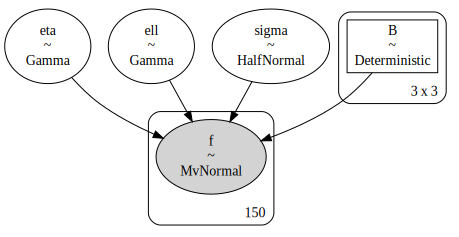

In [13]:
pm.model_to_graphviz(model)

In [14]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 18 seconds.


CPU times: user 55.3 s, sys: 1min 22s, total: 2min 17s
Wall time: 24.8 s


In [15]:
%%time
with model:
    preds = mogp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

CPU times: user 35.4 s, sys: 38.9 s, total: 1min 14s
Wall time: 10.7 s


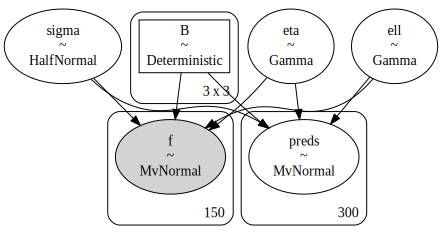

In [16]:
pm.model_to_graphviz(model)

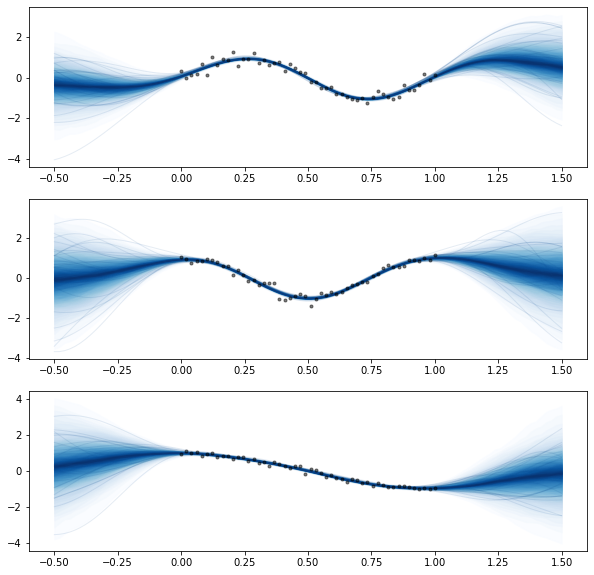

In [17]:
from pymc.gp.util import plot_gp_dist

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
fig, axes = plt.subplots(3,1, figsize=(10,10))

for idx in range(3):
    plot_gp_dist(axes[idx], f_pred[:,n_points*idx:n_points*(idx+1)], 
                 X_new[n_points*idx:n_points*(idx+1),0], 
                 palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
    axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label="Data 1");

In [18]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ell,0.304,0.040,0.232,0.379,0.002,0.002,298.0,243.0,NaN
eta,1.333,0.418,0.740,2.175,0.024,0.017,288.0,170.0,NaN
sigma,0.156,0.009,0.140,0.173,0.001,0.000,232.0,235.0,NaN
"B[0, 0]",0.783,0.000,0.783,0.783,0.000,0.000,500.0,500.0,NaN
"B[0, 1]",0.503,0.000,0.503,0.503,0.000,0.000,500.0,500.0,NaN
"B[0, 2]",0.808,0.000,0.808,0.808,0.000,0.000,500.0,500.0,NaN
"B[1, 0]",0.503,0.000,0.503,0.503,0.000,0.000,500.0,500.0,NaN
"B[1, 1]",1.630,0.000,1.630,1.630,0.000,0.000,500.0,500.0,NaN
"B[1, 2]",1.065,0.000,1.065,1.065,0.000,0.000,500.0,500.0,NaN
"B[2, 0]",0.808,0.000,0.808,0.808,0.000,0.000,500.0,500.0,NaN


### LCM: two or more kernels
$$
K = ( K_{11}(x, x') + K_{12}(x, x') ) * K_2(o, o') 
$$

In [19]:
with pm.Model() as model:
    # Priors
    ell = pm.Gamma("ell", alpha=2, beta=0.5, shape=2)
    eta = pm.Gamma("eta", alpha=3, beta=1, shape=2)
    kernels = [pm.gp.cov.ExpQuad, pm.gp.cov.Matern32]
    sigma = pm.HalfNormal("sigma", sigma=3)
    
    # Define a list of covariance functions
    cov_list = [eta[idx] ** 2 * kernel(2,ls=ell[idx], active_dims=[0]) 
                for idx, kernel in enumerate(kernels)]
    
    # Define a Multi-output GP 
    mogp = MultiOutputMarginal(means=0, kernels=cov_list, input_dim=2, active_dims=[1], num_outputs=3)    
    y_ = mogp.marginal_likelihood("f", X, Y.squeeze(), noise=sigma)    

None
None


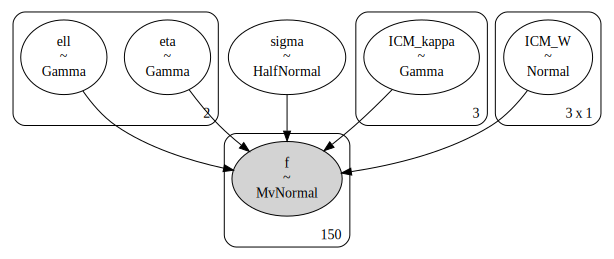

In [20]:
pm.model_to_graphviz(model)
# x1, y1
# x2, y2
# x3, y3

In [21]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, sigma, ICM_kappa, ICM_W]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 93 seconds.


CPU times: user 3min 57s, sys: 7min 46s, total: 11min 44s
Wall time: 1min 40s


In [22]:
%%time
with model:
    preds = mogp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

CPU times: user 48.8 s, sys: 1min 10s, total: 1min 59s
Wall time: 17.3 s


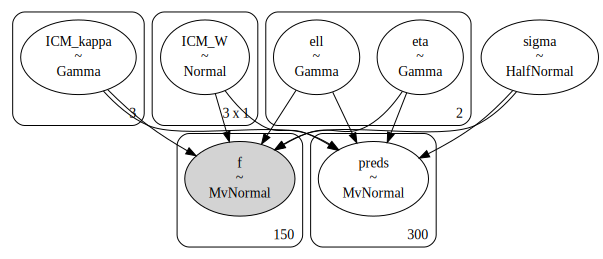

In [23]:
pm.model_to_graphviz(model)

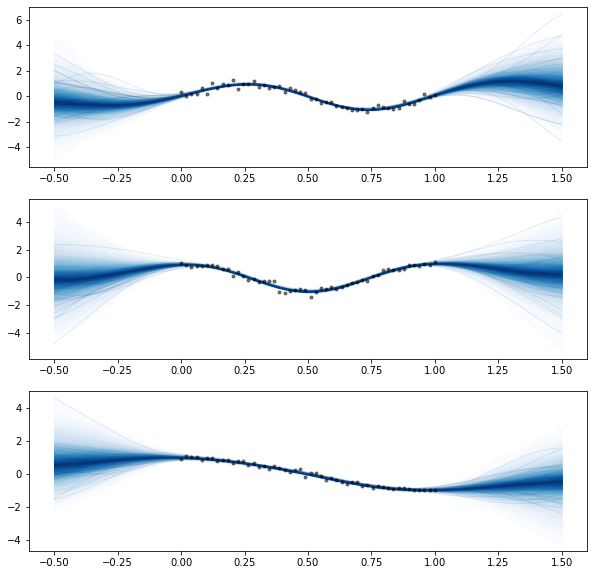

In [24]:
from pymc.gp.util import plot_gp_dist

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
fig, axes = plt.subplots(3,1, figsize=(10,10))

for idx in range(3):
    plot_gp_dist(axes[idx], f_pred[:,n_points*idx:n_points*(idx+1)], 
                 X_new[n_points*idx:n_points*(idx+1),0], 
                 palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
    axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label="Data 1");

In [25]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"ICM_W[0, 0]",-0.028,2.464,-5.053,4.267,0.162,0.114,236.0,275.0,NaN
"ICM_W[1, 0]",0.135,2.409,-4.711,4.523,0.119,0.089,410.0,396.0,NaN
"ICM_W[2, 0]",0.010,1.359,-2.843,2.462,0.072,0.065,362.0,312.0,NaN
ell[0],0.342,0.045,0.269,0.433,0.002,0.002,395.0,388.0,NaN
ell[1],4.898,2.873,0.668,10.170,0.145,0.103,356.0,340.0,NaN
eta[0],0.628,0.258,0.266,1.105,0.015,0.011,328.0,359.0,NaN
eta[1],0.713,0.510,0.086,1.692,0.025,0.017,385.0,364.0,NaN
sigma,0.156,0.010,0.142,0.177,0.000,0.000,563.0,374.0,NaN
ICM_kappa[0],5.215,2.101,1.898,9.280,0.081,0.061,694.0,479.0,NaN
ICM_kappa[1],5.205,2.075,1.950,9.319,0.065,0.051,1054.0,463.0,NaN


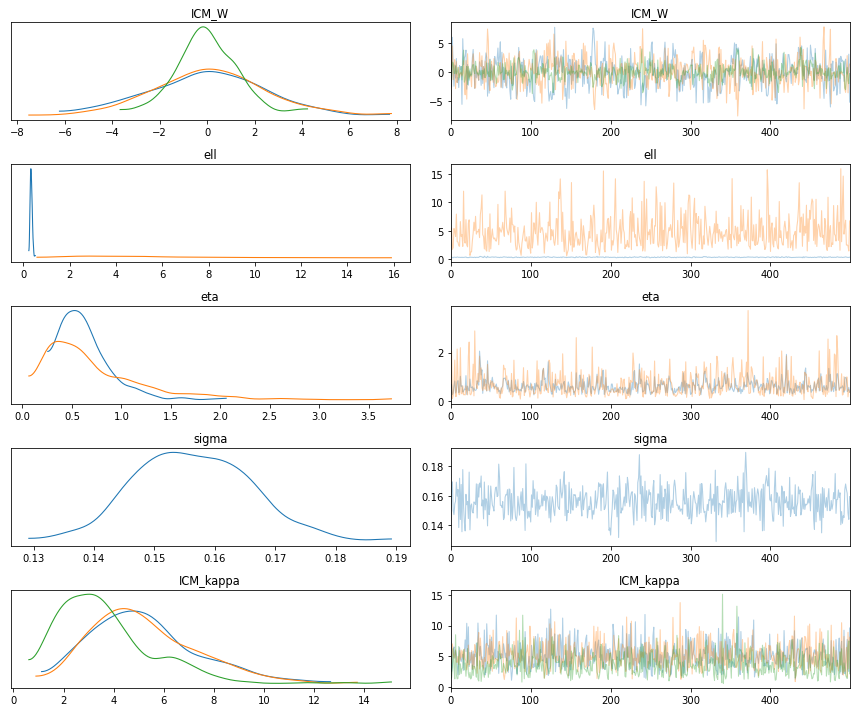

In [26]:
az.plot_trace(gp_trace);
plt.tight_layout()

In [27]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Sep 07 2022

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.3.0

matplotlib: 3.5.2
numpy     : 1.22.4
arviz     : 0.12.1
aesara    : 2.7.9
pymc      : 4.1.5

Watermark: 2.3.0

